In [32]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
using DoubleFloats
using JLD

Solving Stokes equations using Local Hermitian Interpolation with Div-free Polyharmonic kernel with polynomial reproductuion 
Key takeaways:
- It is not proven that div-free matrix kernel formed with polyharmonic RBF is conditionally positive definite, and if it is, which degree of conditionaly positive definitness it has 
- From numerical experiments it seems like it is indeed positive definite even without additional ponynomial basis, but it might be a lucky special case. I assume that matrix kernel formed by polyharmonics retains the same degree of c-pos-def as scalar polyharmonic function that creates it.
- Polynomial basis has to satisfy 2 properties: velocity subspace has to be div-free. pressure subspace can't contain constnt functions, otherwise matrices are degenerate. 
- Local stensil has to have enough points, such that it is m-unisolvent. Higher polynomial degree requires more points in the stencil, oterwise doesn't work. It is somewhat similar to a limit on the accuracy for a given stencil size in classical finite differences. 
- for the same separation distance, polyharmonic div-free kernel has considerably lower kondition number than anything else 
- If a true solution is a polynomial of a degree lower than the degree of the basis, the method recovers the solution with machine precision.

In [155]:
# create functionals
μ = 1.0
ρ = 1.0
@variables ϵ r x₁ x₂ ;
ϕ1 = r^7
ϕ2 = r^3
#ϕ1 = (1-r*ϵ)^10 * (429*(r*ϵ)^4 + 450*(r*ϵ)^3 + 210*(r*ϵ)^2 + 50*(r*ϵ)+5)
#ϕ2 = copy(ϕ1)
ϕ1 = substitute(ϕ1, r=>sqrt(x₁^2 + x₂^2)) 
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2)) 
#ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2))
ϕ1 = simplify(ϕ1,expand = true)
ϕ2 = simplify(ϕ2,expand = true)

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ1)) ∂₁(∂₂(ϕ1)) 0; ∂₁(∂₂(ϕ1)) -∂₁(∂₁(ϕ1)) 0; 0 0 ϕ2])

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1y(x) = -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3])
λ2y(x) = -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])
λ2x(x) = -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3])
λ3x(x) = x[1]
λ4x(x) = x[2]
display(Φ_div)

F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
display(F_A)
F_A_copy = copy(F_A)
F_A = compile_kernel_array(F_A)
F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
#display(F_B)
F_B = compile_kernel_array(F_B)

P_list2D = generate_2D2_div_free_poly_basis(4)
println("N 2D poly ",length(P_list2D))
P_list1D = generate_2D1_poly_basis(3)
println("N 1D poly ",length(P_list1D))
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
#display(P_list)

F_PA = apply_functionals_to_polynomials([λu,λv,λ1x,λ2x,λ3x,λ4x],P_list)
display(F_PA)
F_PA_copy = copy(F_PA)
F_PA = compile_polynomials(F_PA)

F_PB = apply_functionals_to_polynomials([λ1x,λ2x],P_list)
display(F_PB)
F_PB = compile_polynomials(F_PB)

N_poly = size(F_PA)[2]
function create_peconditioner_diagonal(F_A,F_PA)
    @variables r x₁ x₂
    println(typeof(r))
    N_func, N_poly = size(F_PA)
    F_PA_copy = deepcopy(F_PA)
    F_A_copy = deepcopy(F_A)

    F_A_copy = substitute.(F_A_copy, sqrt(x₁^2+x₂^2) => r)
    F_A_copy = substitute.(F_A_copy, x₁ => r)
    F_A_copy = substitute.(F_A_copy, x₂ => r)
    
    F_PA_copy = substitute.(F_PA_copy, sqrt(x₁^2+x₂^2) => r)
    F_PA_copy = substitute.(F_PA_copy, x₁ => r)
    F_PA_copy = substitute.(F_PA_copy, x₂ => r)
    
    display(F_A_copy)
    deg_array = zeros(N_func)
    for i in 1:N_func
        deg = Symbolics.degree(F_A_copy[i,i],r)
        deg_array[i] = deg/2
    end

    deg_array_poly = zeros(N_poly)
    for i in 1:N_poly
        for j in 1:N_func
            if !isequal(F_PA_copy[j,i],0)
                deg = (Symbolics.degree(F_PA_copy[j,i],r))
                deg_array_poly[i] = deg - deg_array[j]
                break
            end
        end

        """
        if !isequal(F_PA_copy[1,i],0)
            deg = (Symbolics.degree(F_PA_copy[1,i],r))
            deg_array_poly[i] = deg - deg_array[1]
        elseif !isequal(F_PA_copy[2,i],0)
            deg = (Symbolics.degree(F_PA_copy[2,i],r))
            deg_array_poly[i] = deg - deg_array[2]
        elseif !isequal(F_PA_copy[3,i],0)
            deg = (Symbolics.degree(F_PA_copy[3,i],r))
            deg_array_poly[i] = deg - deg_array[3]
        elseif !isequal(F_PA_copy[4,i],0)
            deg = (Symbolics.degree(F_PA_copy[4,i],r))
            deg_array_poly[i] = deg - deg_array[4]
        end
        """
    end
    #println(deg_array)
    return deg_array ,deg_array_poly
end
#deg_array_boundary ,deg_array_poly_boundary = create_peconditioner_diagonal(F_A_copy,F_PA_copy)
#deg_array_internal ,deg_array_poly_internal = create_peconditioner_diagonal(F_A_copy[1:4,1:4],F_PA_copy[1:4,:])
#println(deg_array_boundary)
#println(deg_array_poly_boundary)
println("done n_poly ",N_poly)

3×3 Matrix{Num}:
 -7(sqrt(x₁^2 + x₂^2)^5) - 35(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)  …                    0
                            35x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                       0
                                                        0     sqrt(x₁^2 + x₂^2)^3

6×6 Matrix{Num}:
 -7(sqrt(x₁^2 + x₂^2)^5) - 35(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)                                                                                                                                                                                                                                               …                             35x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)
                            35x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                                                                                                                                                                                                                                                  -7(sqrt(x₁^2 + x₂^2)^5) - 35(x₁^2)*(sqrt(x₁^2 + x₂^2)^3)
                                                     (105.0(x₂^4) + 105.0(sqrt(x₁^2 + x₂^2)^4) + 630.0(x₂^2)*(sqrt(x₁^2 + x₂^2)^2)) / sqrt(x₁^2 + x₂^2) + (35.0(sqrt(x₁^2 + x₂^2)^4) + 105.0(x₁^2)*(x₂^2) + 105.0(x₁^2)*(sqrt(x₁^2 + x₂^2)^2) + 105.0(x₂^2)*(sqrt(x₁^2 + x₂^2)^

6×29 Matrix{Num}:
 1    x₂     x₁    x₂^2             x₁*x₂    …       0.0       0.0        0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)            0.0       0.0        0.0
 0.0   0.0    0.0    -2.0               0.0       x₂^2    2x₁*x₂    3(x₁^2)
 0.0   0.0    0.0     0.0               1.0     2x₁*x₂      x₁^2          0.0
 1    x₂     x₁    x₂^2             x₁*x₂            0.0       0.0        0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)    …       0.0       0.0        0.0

2×29 Matrix{Num}:
 0.0  0.0  0.0  -2.0  0.0  -2.0  -6.0x₂  -2.0x₁  …    x₂^2  2x₁*x₂  3(x₁^2)
 0.0  0.0  0.0   0.0  1.0   0.0   0.0     2.0x₂     2x₁*x₂    x₁^2        0.0

N 2D poly 20
N 1D poly 10


done n_poly 29


In [156]:
# create true solution
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))

u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y)

#u = 20*x*y^3
#v = 5*x^4 - 5*y^4
#p = 60*x*x*y - 20*y*y*y 
display(dx(u)+dy(v))
F1 = -(μ/ρ)*(dx(dx(u)) + dy(dy(u))) + dx(p)/ρ
F2 = -(μ/ρ)*(dx(dx(v)) + dy(dy(v))) + dy(p)/ρ
display(F1)
display(F2)
#f1 = eval(build_function(f1,x,y))
#f2 = eval(build_function(f2,x,y))
#true_v1 = eval(build_function(u,x,y))
#true_v2 = eval(build_function(v,x,y))

#f1(x,y) = 8.0y*cos(x^2 + y^2) + cos(x - y) - 4.0(y^3)*sin(x^2 + y^2) - 4.0y*(x^2)*sin(x^2 + y^2)
#f2(x,y) = 4.0(x^3)*sin(x^2 + y^2) + 4.0x*(y^2)*sin(x^2 + y^2) - cos(x - y) - 8.0x*cos(x^2 + y^2)
#gu(x,y) = -y*sin(x^2 + y^2)
#gv(x,y) =  x*sin(x^2 + y^2)

f1(x,y) = 0.0
f2(x,y) = 0.0
gu(x,y) = 20*x*y^3
gv(x,y) =  5*x^4 - 5*y^4


"""
function gu(x,y)

    if abs(y-1) < 1e-10 
        return 1#-(0.5-x)^2 + 0.25
    else
        return 0.0
    end

    return true_v1(x,y)
end
gv(x,y) = true_v2(x,y)
"""


f1(Double64.(0.9),Double64.(0.9))




0

8.0y*cos(x^2 + y^2) + cos(x - y) - 4.0(y^3)*sin(x^2 + y^2) - 4.0y*(x^2)*sin(x^2 + y^2)

4.0(x^3)*sin(x^2 + y^2) + 4.0x*(y^2)*sin(x^2 + y^2) - cos(x - y) - 8.0x*cos(x^2 + y^2)

0.0

2×76 Matrix{Float64}:
 0.0  0.0        0.0       0.0       …  1.0       1.0       1.0       1.0
 0.0  0.0526316  0.105263  0.157895     0.842105  0.894737  0.947368  1.0

[0.0, 0.0]
[0.0, 1.0]
[1.0, 0.0]
[1.0, 1.0]


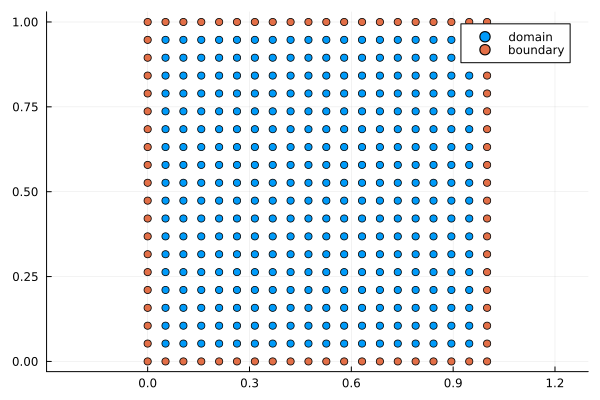

In [169]:
# create points 
N_side = 20
I_points, B_points = generate_2D_equally_spaced_points(N_side)
#I_points = Double64.(I_points)
#B_points = Double64.(B_points)
All_points = (hcat(I_points, B_points))
N_I = size(I_points)[2]
N_B = size(B_points)[2]
N_tot = N_I + N_B 
#all_points = [domain_p boundary_p]
println(B_points[:,1])
println(B_points[:,N_side])
println(B_points[:,3*N_side-3])
println(B_points[:,4*N_side-4])
#B_points = B_points[:, setdiff(1:end,[1,N_side,4*N_side-4,3*N_side-3])]
display(B_points)
scatter(I_points[1,:],I_points[2,:],label="domain",aspect_ratio = :equal)
scatter!(B_points[1,:],B_points[2,:],label="boundary")

In [170]:
# assemble matrices and rhs 

k =30
scale = 20
param = 0.1
r = 2*1.42/(N_side-1)
I_tree = KDTree(I_points,Euclidean(),leafsize = 3)
B_tree = KDTree(B_points,Euclidean(),leafsize = 3)
All_tree  = KDTree(All_points,Euclidean(),leafsize = 3)
neighbours,_ = knn(All_tree, I_points, k, true) 

neighbours_I = inrange(I_tree, I_points, r, true)
neighbours_B = inrange(B_tree, I_points, r, true)
#display(neighbours_I)
G = (zeros(2*N_I,2*N_I)) # global sprse matrix 
#Global_RHS = zeros(2*N_I)
Global_RHS = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
cond_num_array = zeros(N_I)
for i in 1:N_I
    I_idx = neighbours_I[i]
    deleteat!(I_idx, findall(x->x==i,I_idx))
    B_idx = neighbours_B[i]

    #I_idx = neighbours[i][findall(x -> x<=N_I , neighbours[i])]
    #deleteat!(I_idx, findall(x->x==i,I_idx))
    #B_idx = neighbours[i][findall(x -> x>N_I , neighbours[i])] .-N_I 

    Local_B_points = B_points[:,B_idx] .- reshape(I_points[:,i],(2,1))
    Local_I_points = I_points[:,I_idx] .- reshape(I_points[:,i],(2,1))
    #Local_B_points = Double64.(Local_B_points)
    #Local_I_points = Double64.(Local_I_points)
    N_I_local = size(Local_I_points)[2]
    N_B_local = size(Local_B_points)[2]

    Full_Local_I_points = hcat(I_points[:,i],I_points[:,I_idx]) .- reshape(I_points[:,i],(2,1))# internal points including center 
    #Full_Local_I_points = Double64.(Full_Local_I_points)
    default_point_list = [Full_Local_I_points,Full_Local_I_points,Local_I_points,Local_I_points] # list of points if no boundary is present
    #println(typeof(default_point_list))
    sample_point_list = [reshape([0.0,0.0],(2,1)),reshape([0.0,0.0],(2,1))]
    #sample_point_list = [reshape(I_points[:,i],(2,1)),reshape(I_points[:,i],(2,1))]
    L_RHS = vcat(f1.(I_points[1,I_idx],I_points[2,I_idx]),f2.(I_points[1,I_idx],I_points[2,I_idx]))
    if isempty(B_idx)
        #d = vcat(ones(2*N_I_local+2)*(scale^2.5),ones(2*N_I_local)*(scale^0.5))
        #DM = diagm(0 => vcat(d,scale .^ deg_array_poly_boundary))

        PA = generate_P_matrix(default_point_list,F_PA[1:end-2,:])
        
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A[1:4,1:4],T,param))
        #display(A)
        B = flatten(generate_block_matrices(F_B[:,1:4],T2,param))
        RHS = vcat(L_RHS,zeros(N_poly))
        
        status = "interiror"
    else
        #d = vcat(ones(2*N_I_local+2)*(scale^2.5),ones(2*N_I_local)*(scale^0.5),ones(2*N_B_local)*(scale^2.5))
        #DM = diagm(0 => vcat(d,scale .^ deg_array_poly_internal))
        append!(default_point_list,[Local_B_points,Local_B_points])
        PA = generate_P_matrix(default_point_list,F_PA[1:end,:])
        T = crete_block_point_tensors(default_point_list,default_point_list)
        T2 = crete_block_point_tensors(sample_point_list,default_point_list)
        A = flatten(generate_block_matrices(F_A,T,param))
        B = flatten(generate_block_matrices(F_B,T2,param))
  
        RHS = vcat(L_RHS,gu.(B_points[1,B_idx],B_points[2,B_idx]),gv.(B_points[1,B_idx],B_points[2,B_idx])
        ,zeros(N_poly))

        status = "boundary"

    end
    #display(A)
    #display(RHS)
    O = zeros(N_poly,N_poly)
    M = [A PA;PA' O]
    #M = A
    #display(M)
    cond_num_array[i] = cond(M)
    PB = generate_P_matrix(sample_point_list,F_PB)
    N_I_local = length(I_idx)+1 # total number of local internal points counting the center
    #C = [B PB]*(DM*inv(DM*M*DM)*DM)
    #M = Double64.(M)
    C = [B PB]*inv(M)
    #C = B*inv(M)
    #display(C)
    #C = Float64.(C)
    G[[i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I)] .= C[:,1:2*N_I_local]

    Global_RHS[[i,N_I+i]] .+= -(C[:,1+2*N_I_local:end] * RHS[1:end]) 

end
println("max local cond number: ",maximum(cond_num_array))
#println("global condition number: ",cond(Matrix(G)))
#display(Global_RHS)
#display(length(sparse(G).nzval)/(4*N_I^2))

global_cond = cond(G)
display(global_cond)
display(G)

33119.759888235334

648×648 Matrix{Float64}:
  3605.48   -6916.05   -1547.63   …      0.0        0.0        0.0
 -2243.33    5175.48   -1651.57          0.0        0.0        0.0
  -627.553  -1452.31    5345.59          0.0        0.0        0.0
     0.0     -627.553  -1452.31          0.0        0.0        0.0
     0.0        0.0     -627.553         0.0        0.0        0.0
     0.0        0.0        0.0    …      0.0        0.0        0.0
     0.0        0.0        0.0           0.0        0.0        0.0
     0.0        0.0        0.0           0.0        0.0        0.0
     0.0        0.0        0.0           0.0        0.0        0.0
     0.0        0.0        0.0           0.0        0.0        0.0
     ⋮                            ⋱      ⋮                 
     0.0        0.0        0.0           0.0        0.0        0.0
     0.0        0.0        0.0    …      0.0        0.0        0.0
     0.0        0.0        0.0           0.0        0.0        0.0
     0.0        0.0        0.0           0.0

max local cond number: 1.4124226601005914e11

max error: 4.377511825899225e-9


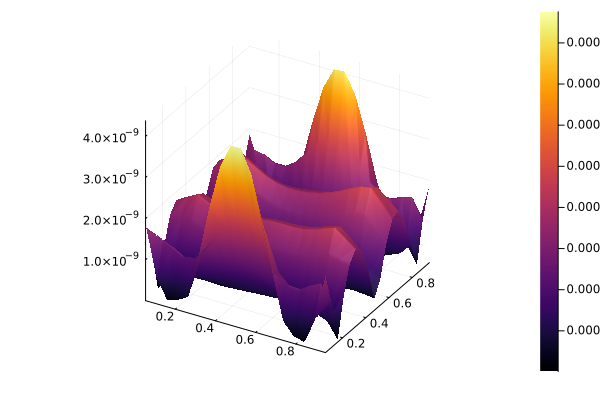

In [171]:
reference_v = vcat(gu.(I_points[1,:],I_points[2,:]),gv.(I_points[1,:],I_points[2,:]))
#N_I*2
#cond(Matrix(G))
#println(reference_v)
sol = G\Global_RHS
error = abs.(sol - reference_v)
println("max error: ",maximum(error))
#display(maximum(error))
#surface(I_points[1,:],I_points[2,:],reference_v[1:N_I])
#surface(I_points[1,:],I_points[2,:],sol[1:N_I])
surface(I_points[1,:],I_points[2,:],error[1:N_I])

In [172]:
function compute_error(N,r)
    N_side = N
    I_points, B_points = generate_2D_equally_spaced_points(N_side)
    All_points = (hcat(I_points, B_points))
    N_I = size(I_points)[2]
    N_B = size(B_points)[2]
    N_tot = N_I + N_B 
    param = 0.1
    I_tree = KDTree(I_points,Euclidean(),leafsize = 3)
    B_tree = KDTree(B_points,Euclidean(),leafsize = 3)
    All_tree  = KDTree(All_points,Euclidean(),leafsize = 3)
    neighbours,_ = knn(All_tree, I_points, k, true) 

    neighbours_I = inrange(I_tree, I_points, r, true)
    neighbours_B = inrange(B_tree, I_points, r, true)
    #display(neighbours_I)
    G = zeros(2*N_I,2*N_I) # global sprse matrix 
    #Global_RHS = zeros(2*N_I)
    Global_RHS = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
    cond_num_array = zeros(N_I)
    for i in 1:N_I
        I_idx = neighbours_I[i]
        deleteat!(I_idx, findall(x->x==i,I_idx))
        B_idx = neighbours_B[i]
        #I_idx, _ = knn(I_tree, I_points[:,i], k, true)
        #I_idx = neighbours[i][findall(x -> x<=N_I , neighbours[i])][2:end]
        #B_idx = neighbours[i][findall(x -> x>N_I , neighbours[i])] .-N_I 

        Local_B_points = B_points[:,B_idx] .- reshape(I_points[:,i],(2,1))
        Local_I_points = I_points[:,I_idx] .- reshape(I_points[:,i],(2,1))
        N_I_local = size(Local_I_points)[2]
        N_B_local = size(Local_B_points)[2]

        Full_Local_I_points = hcat(I_points[:,i],I_points[:,I_idx]) .- reshape(I_points[:,i],(2,1))# internal points including center 

        default_point_list = [Full_Local_I_points,Full_Local_I_points,Local_I_points,Local_I_points] # list of points if no boundary is present
        sample_point_list = [reshape([0.0,0.0],(2,1)),reshape([0.0,0.0],(2,1))]
        #sample_point_list = [reshape(I_points[:,i],(2,1)),reshape(I_points[:,i],(2,1))]
        L_RHS = vcat(f1.(I_points[1,I_idx],I_points[2,I_idx]),f2.(I_points[1,I_idx],I_points[2,I_idx]))
        if isempty(B_idx)
            d = vcat(ones(2*N_I_local+2)*(scale^2.5),ones(2*N_I_local)*(scale^0.5))
            DM = diagm(0 => vcat(d,scale .^ deg_array_poly_boundary))

            PA = generate_P_matrix(default_point_list,F_PA[1:end-2,:])
            
            T = crete_block_point_tensors(default_point_list,default_point_list)
            T2 = crete_block_point_tensors(sample_point_list,default_point_list)
            A = flatten(generate_block_matrices(F_A[1:4,1:4],T,param))
            B = flatten(generate_block_matrices(F_B[:,1:4],T2,param))
            RHS = vcat(L_RHS,zeros(N_poly))

            status = "interiror"
        else
            d = vcat(ones(2*N_I_local+2)*(scale^2.5),ones(2*N_I_local)*(scale^0.5),ones(2*N_B_local)*(scale^2.5))
            DM = diagm(0 => vcat(d,scale .^ deg_array_poly_internal))
            append!(default_point_list,[Local_B_points,Local_B_points])
            PA = generate_P_matrix(default_point_list,F_PA[1:end,:])
            T = crete_block_point_tensors(default_point_list,default_point_list)
            T2 = crete_block_point_tensors(sample_point_list,default_point_list)
            A = flatten(generate_block_matrices(F_A,T,param))
            B = flatten(generate_block_matrices(F_B,T2,param))
    
            RHS = vcat(L_RHS,gu.(B_points[1,B_idx],B_points[2,B_idx]),gv.(B_points[1,B_idx],B_points[2,B_idx])
            ,zeros(N_poly))

            status = "boundary"

        end
        O = zeros(N_poly,N_poly)
        M = [A PA;PA' O]
        cond_num_array[i] = cond(M)
        PB = generate_P_matrix(sample_point_list,F_PB)
        N_I_local = length(I_idx)+1 # total number of local internal points counting the center
        #C = [B PB]*(DM*inv(DM*M*DM)*DM)
        M = Double64.(M)
        C = [B PB]*inv(M)
        C = Float64.(C)
        G[[i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I)] .= C[:,1:2*N_I_local]

        Global_RHS[[i,N_I+i]] .+= -(C[:,1+2*N_I_local:end] * RHS) 

    end
    max_local_cond = maximum(cond_num_array)
    global_cond = cond(G)
    reference_v = vcat(true_v1.(I_points[1,:],I_points[2,:]),true_v2.(I_points[1,:],I_points[2,:]))

    sol = G\Global_RHS
    error = abs.(sol - reference_v)
    return maximum(error),max_local_cond,global_cond
end
#compute_error(20,3*1.45/(10-1))
#JLD.save("saved_benchmarks/LHI_polyharm4_3_r2_20.jld", "error", maximum(error), "max_local_cond", maximum(cond_num_array), "sep_dist",N_side, "N_stencil",k, "global_cond", global_cond)

In [137]:
JLD.load("saved_benchmarks/LHI_wendland_r4_30.jld")

Dict{String, Any} with 5 entries:
  "global_cond"    => 1.29797e5
  "max_local_cond" => 2.48145e18
  "sep_dist"       => 30
  "error"          => 0.0022755152765933312
  "N_stencil"      => 30

In [ ]:
N_array = [8,10,12,15]
error_array = []
local_cond_array = []
global_cond_array = []

for N in N_array
    err,max_local_cond,global_cond = compute_error(N,4/(N-1))
    append!(error_array,err)
    append!(local_cond_array,max_local_cond)
    append!(global_cond_array,global_cond)
    println("done")
end
#JLD.save("saved_benchmarks/LHI_polyharm_k50_40.jld", "error", maximum(error), "max_local_cond", maximum(cond_num_array), "sep_dist",N_side, "N_stencil",k, "global_cond", global_cond)

In [ ]:
error_array


In [ ]:
function plot_arrow!(x1,y1,x2,y2)
    color = :blue
    arr_width = 0.2
    vx = x2-x1
    vy = y2 -y1
    l_arr = sqrt(vx*vx+vy*vy)
    pqx= x1+3*(x2-x1)/4
    pqy= y1+3*(y2-y1)/4 # quarterpoint

    vpx = 1
    vpy = -vx/vy
    lp = sqrt(vpx*vpx + vpy*vpy)
    vpx = vpx/lp
    vpy = vpy/lp 

    p1ax = pqx + vpx*l_arr*arr_width
    p1ay = pqy + vpy*l_arr*arr_width

    p2ax = pqx - vpx*l_arr*arr_width
    p2ay = pqy - vpy*l_arr*arr_width

    plot!([x1,x2],[y1,y2],c=color,label = false) # line
    trian = Shape([(p1ax, p1ay),(p2ax,p2ay), (x2,y2), (p1ax, p1ay)])
    plot!(trian, c = color,label = false,linewidth = 0)
end

function visualize_vec_field(Points,u,v)
    scale = 0.05
    vel = sqrt.(u.^2 .+ v .^2)
    mx = maximum(vel)
    print(size(Points))
    plot()
    for i in 1:size(Points)[2]
        px,py = Points[:,i]
        print(px,py)
        #plot!([px,px+scale*u[i]/mx],[py,py+scale*v[i]/mx],label = false,arrow = arrow(),)
        plot_arrow!(px,py,px+scale*u[i]/mx,py+scale*v[i]/mx)
    end
    plot!()
end


visualize_vec_field(I_points,sol[1:N_I],sol[1+N_I:end])

In [213]:
using LaTeXStrings
# plot all this hell 
#display(JLD.load("saved_benchmarks/LHI_polyharm_k50_40.jld"))
poly_r2 = ["saved_benchmarks/LHI_polyharm_r2_10.jld","saved_benchmarks/LHI_polyharm_r2_20.jld","saved_benchmarks/LHI_polyharm_r2_30.jld","saved_benchmarks/LHI_polyharm_r2_40.jld"]
poly_reproduction_r2 = ["saved_benchmarks/LHI_polyharm4_3_r2_10.jld","saved_benchmarks/LHI_polyharm4_3_r2_20.jld","saved_benchmarks/LHI_polyharm4_3_r2_30.jld","saved_benchmarks/LHI_polyharm4_3_r2_40.jld"]
wend_r2 = ["saved_benchmarks/LHI_wendland_r2_10.jld","saved_benchmarks/LHI_wendland_r2_20.jld","saved_benchmarks/LHI_wendland_r2_30.jld","saved_benchmarks/LHI_wendland_r2_40.jld"]
#wend_r2 = ["saved_benchmarks/LHI_wendland_k50_10.jld","saved_benchmarks/LHI_wendland_k50_20.jld","saved_benchmarks/LHI_wendland_k50_30.jld","saved_benchmarks/LHI_wendland_k50_40.jld"]
saves = [poly_r2,poly_reproduction_r2,wend_r2]
p2  =Dict("err" => [],"g_cond" => [],"loc_cond" => [],"h" => [])
p_rep  =Dict("err" => [],"g_cond" => [],"loc_cond" => [],"h" => [])
w2  =Dict("err" => [],"g_cond" => [],"loc_cond" => [],"h" => [])

lines = [p2,p_rep,w2]
for j in 1:3
for i in 1:4
    d = JLD.load(saves[j][i]) 
    append!(lines[j]["err"],d["error"])
    append!(lines[j]["g_cond"],d["global_cond"])
    append!(lines[j]["loc_cond"],d["max_local_cond"])
    append!(lines[j]["h"],d["sep_dist"])
end
end
plot(xaxis = L"h",yaxis = L"{||e||}_{\infty}")
plot!(p2["h"] .^-1,p2["err"],scale = :log10, label="Polyharmonics",linestyle = :dash)
scatter!(p2["h"].^-1,p2["err"],scale = :log10, label = false,)

#plot!(p_rep["h"].^-1,p_rep["err"],scale = :log10,label="p50")
#scatter!(p_rep["h"].^-1,p_rep["err"],scale = :log10, label = false)

plot!(w2["h"].^-1,w2["err"],scale = :log10,label="Wendland")
scatter!(w2["h"].^-1,w2["err"],scale = :log10, label = false)
savefig("report_figures/LHI.png")

plot(xaxis = L"h",yaxis = L"{||e||}_{\infty}",size = (600,200))

plot!(p_rep["h"].^-1,p_rep["err"],scale = :log10,label="Polyharmonics 4 3")
scatter!(p_rep["h"].^-1,p_rep["err"],scale = :log10, label = false)


savefig("report_figures/LHI_poly_reproduction.png")




┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Volodymyr\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Volodymyr\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Volodymyr\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Volodymyr\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


"c:\\Users\\Volodymyr\\OneDrive\\Documents\\Masters\\thesis\\coding\\report_figures\\LHI_poly_reproduction.png"